# Chapter 7: Forecast of Well Production (Decline Curve Analysis)
**Objective:** Forecast future production and estimate reserves (EUR) using Arps' Decline Curve Analysis (DCA).

**Author:** Ade Anggi Naluriawan Santoso

Once a well has passed its initial "transient" flow period and reservoir boundaries are felt (Pseudo-Steady State), production typically declines as reservoir pressure drops.

**Arps' Equations (1945):**
The industry standard model relates flow rate ($q$) to time ($t$) using three parameters:
1.  $q_i$: Initial production rate.
2.  $d_i$: Initial nominal decline rate.
3.  $b$: The decline exponent (b-factor), which dictates the curvature.

**Three Types of Decline:**
* **Exponential ($b=0$):** Common for low-permeability or gravity drainage reservoirs.
* **Harmonic ($b=1$):** Common for water-drive reservoirs.
* **Hyperbolic ($0 < b < 1$):** The general case for most solution-gas drive reservoirs.

$$q(t) = \frac{q_i}{(1 + b d_i t)^{1/b}}$$

*(Note: When $b=0$, this equation mathematically limits to $q_i e^{-d_i t}$)*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Defining the Arps Model
We need a robust Python function that handles the transition from Hyperbolic to Exponential automatically.

**Note on Units:**
* Time ($t$) is usually in **Months** for data fitting.
* Decline Rate ($d_i$) must be consistent with time (1/Month).

In [2]:
def arps_rate(t, qi, di, b):
    """
    Calculates rate at time t using Arps equation.
    Handles Exponential (b=0), Harmonic (b=1), and Hyperbolic.
    """
    # Prevent division by zero or complex numbers with bad inputs
    if qi < 0 or di < 0: 
        return np.zeros_like(t)
    
    # Exponential Decline (b ~ 0)
    # We use a small epsilon because exactly 0 can cause division errors in the general formula
    if abs(b) < 1e-4:
        return qi * np.exp(-di * t)
    
    # Hyperbolic / Harmonic
    else:
        # Base = (1 + b * di * t)
        base = 1 + b * di * t
        
        # Safety: base must be positive
        # In rare math cases, if b is negative (unphysical), this breaks.
        # We assume standard physics: base > 0
        return qi / (base ** (1 / b))

## 2. Generating Synthetic Data
Since we don't have a live database, let's simulate a well ("Well Z") that has been producing for **24 months**. We will add some "noise" to simulate real-world gauge fluctuations.

* **True Parameters:** $q_i=1000$, $d_i=0.05$ (5% per month), $b=0.4$

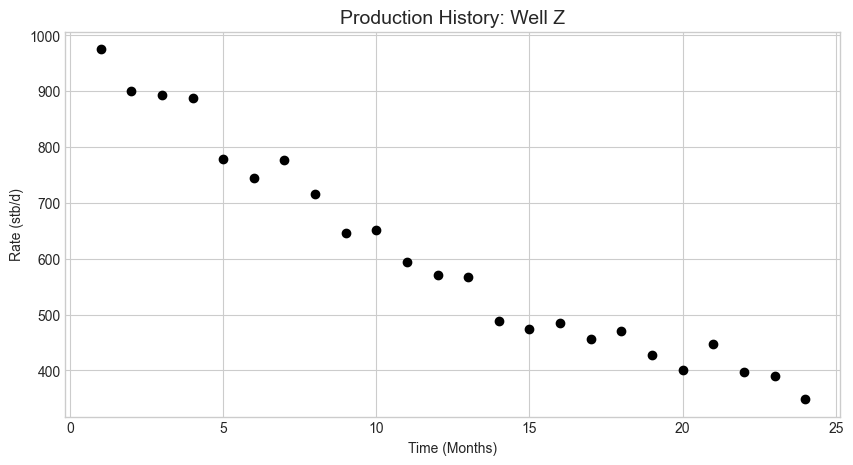

In [3]:
# 1. Create Time Vector (Months 1 to 24)
t_history = np.linspace(1, 24, 24)

# 2. Generate "True" Data
true_qi = 1000
true_di = 0.05
true_b = 0.4

q_true = arps_rate(t_history, true_qi, true_di, true_b)

# 3. Add Noise (Random fluctuations +/- 10%)
np.random.seed(42) # For reproducible results
noise = np.random.normal(0, 0.05 * q_true, len(t_history)) # 5% std dev noise
q_history = q_true + noise

# 4. Visualize History
plt.figure(figsize=(10, 5))
plt.scatter(t_history, q_history, color='black', label='Production History')
plt.title("Production History: Well Z", fontsize=14)
plt.xlabel("Time (Months)")
plt.ylabel("Rate (stb/d)")
plt.grid(True)
plt.show()

## 3. Automated Curve Fitting
This is where Python shines. Instead of manually dragging lines in Excel/software, we use **`scipy.optimize.curve_fit`** to mathematically minimize the error between the Arps model and our data.

We provide **bounds** to keep the physics realistic:
* $q_i$: 500 to 2000
* $d_i$: 0 to 1 (0% to 100% decline)
* $b$: 0 to 1 (Standard Arps bounds)

In [4]:
# Define Bounds for parameters [qi, di, b]
# Lower bounds: [0, 0, 0]
# Upper bounds: [2000, 0.2, 1.0] (Assume max 20% decline per month, b max 1)
param_bounds = ([100, 0.0, 0.0], [2000, 0.5, 1.0])

# Perform Curve Fit
# popt = optimized parameters, pcov = covariance matrix (error)
popt, pcov = curve_fit(arps_rate, t_history, q_history, bounds=param_bounds)

# Extract results
qi_fit, di_fit, b_fit = popt

print("--- DCA Fitting Results ---")
print(f"qi (Initial Rate): {qi_fit:.2f} stb/d (True: {true_qi})")
print(f"di (Decline Rate): {di_fit*100:.2f} %/mo (True: {true_di*100}%)")
print(f"b  (Exponent):     {b_fit:.3f}      (True: {true_b})")

--- DCA Fitting Results ---
qi (Initial Rate): 1034.28 stb/d (True: 1000)
di (Decline Rate): 5.37 %/mo (True: 5.0%)
b  (Exponent):     0.363      (True: 0.4)


## 4. Forecasting and Reserves (EUR)
Now that we have the equation, we can project it into the future.
* **Forecast Duration:** Next 5 years (60 months).
* **Economic Limit:** Calculate Cumulative Production ($N_p$) until the rate hits 50 stb/d.

**Cumulative Production Equation ($N_p$):**
For Hyperbolic ($b > 0$):
$$N_p(t) = \frac{q_i^b}{(1-b)d_i} [q_i^{1-b} - q(t)^{1-b}]$$

In [5]:
def arps_cumulative(q_start, q_end, di, b):
    """
    Calculates Cumulative Production given start/end rates.
    This avoids integrating time steps manually.
    """
    if abs(b) < 1e-4:
        # Exponential: Np = (qi - q) / di
        return (q_start - q_end) / di
    elif abs(b - 1.0) < 1e-4:
        # Harmonic: Np = (qi / di) * ln(qi / q)
        return (q_start / di) * np.log(q_start / q_end)
    else:
        # Hyperbolic
        term1 = (q_start ** b) / ((1 - b) * di)
        term2 = (q_start ** (1 - b)) - (q_end ** (1 - b))
        return term1 * term2

# --- GENERATE FORECAST ---
# Time vector for next 60 months (Months 24 to 84)
t_forecast = np.linspace(24, 84, 60)
q_forecast = arps_rate(t_forecast, qi_fit, di_fit, b_fit)

# --- CALCULATE RESERVES ---
economic_limit = 50 # stb/d
current_rate = q_forecast[0]

# Remaining Reserves (from now until limit)
# Note: We must ensure we don't forecast past the limit in the calc
if current_rate > economic_limit:
    reserves = arps_cumulative(current_rate, economic_limit, di_fit, b_fit)
else:
    reserves = 0

# Convert Rate (stb/d) and Decline (1/mo) to Volume (stb)
# The formula Np = (q1 - q2)/d works if q and d have SAME time units.
# q is /day, d is /month. We need to convert d to /day OR q to /month.
# Easier: Multiply Np result by 30.4 (avg days per month)
reserves_bbl = reserves * 30.416 

print(f"Economic Limit: {economic_limit} stb/d")
print(f"Remaining Reserves: {reserves_bbl/1000:.2f} MSTB")

Economic Limit: 50 stb/d
Remaining Reserves: 228.70 MSTB


## 5. Final Visualization
Plot the history, the mathematical fit, and the future forecast.

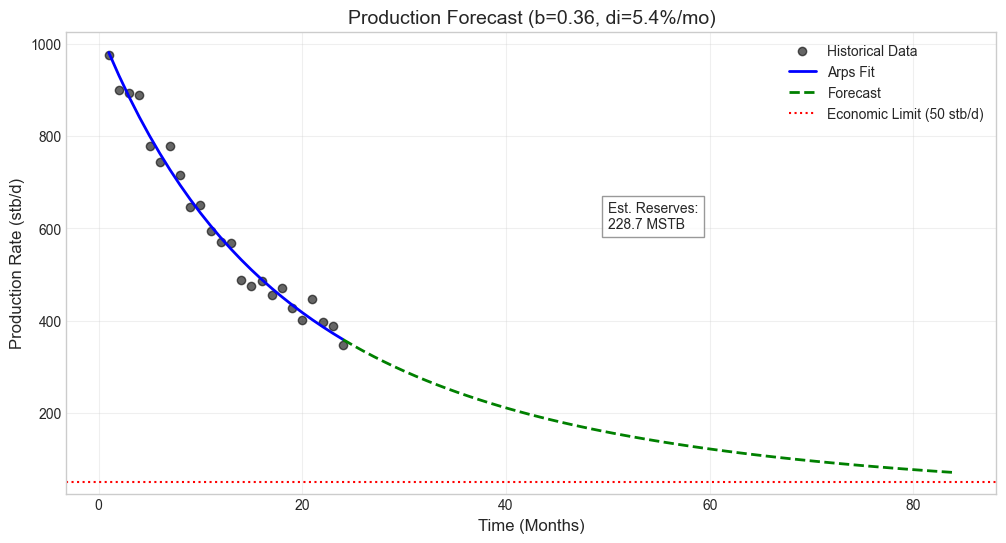

In [6]:
plt.figure(figsize=(12, 6))

# 1. History Data
plt.scatter(t_history, q_history, color='black', alpha=0.6, label='Historical Data')

# 2. The Fit (Over history)
plt.plot(t_history, arps_rate(t_history, *popt), color='blue', linewidth=2, label='Arps Fit')

# 3. The Forecast (Future)
plt.plot(t_forecast, q_forecast, color='green', linestyle='--', linewidth=2, label='Forecast')

# 4. Economic Limit Line
plt.axhline(economic_limit, color='red', linestyle=':', label='Economic Limit (50 stb/d)')

plt.title(f"Production Forecast (b={b_fit:.2f}, di={di_fit:.1%}/mo)", fontsize=14)
plt.xlabel("Time (Months)", fontsize=12)
plt.ylabel("Production Rate (stb/d)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Add text box for EUR
plt.text(50, 600, f"Est. Reserves:\n{reserves_bbl/1000:.1f} MSTB", 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

plt.show()

## Summary
You have built a fully automated **Decline Curve Analysis** tool.

**Key Takeaways:**
1.  **Noise Handling:** Real data is messy. `curve_fit` finds the best trend through the noise.
2.  **Constraint Management:** We forced $0 \le b \le 1$ to respect physical laws (b > 1 is usually transient flow, not boundary dominated).
3.  **Reserves Calculation:** We integrated the rate curve to find volumes (MSTB) without needing complex summation loops.